In [1]:
!git clone https://github.com/cfteach/modules.git
!pip install pymoo
!pip install ipyvolume
  


Cloning into 'modules'...
remote: Enumerating objects: 21, done.
remote: Counting objects: 100% (21/21), done.
remote: Compressing objects: 100% (20/20), done.
remote: Total 21 (delta 3), reused 9 (delta 0), pack-reused 0
Unpacking objects: 100% (21/21), done.
     |████████████████████████████████| 2.5 MB 4.9 MB/s 
     |████████████████████████████████| 239 kB 18.6 MB/s 
     |████████████████████████████████| 2.9 MB 5.4 MB/s 
     |████████████████████████████████| 260 kB 46.4 MB/s 
     |████████████████████████████████| 3.4 MB 31.2 MB/s 
     |████████████████████████████████| 275 kB 53.2 MB/s 


In [2]:
%load_ext autoreload 
%autoreload 2

import ipyvolume as ipv
import ipywidgets as widgets

from IPython.display import display, Math, Latex


import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
#import AI4NP_detector_opt.sol2.detector2 as detector2 
import modules.detector2 as detector2
import re
import pickle
import dill

from pymoo.algorithms.moo.nsga2 import NSGA2
#from pymoo.factory import Problem
from pymoo.core.problem import Problem
from pymoo.core.problem import ElementwiseProblem
from pymoo.optimize import minimize
from pymoo.visualization.scatter import Scatter
"""
from pymoo.algorithms.nsga2 import NSGA2
from pymoo.model.problem import Problem
from pymoo.optimize import minimize
from pymoo.visualization.scatter import Scatter
"""
from pymoo.factory import get_visualization, get_decomposition
from pymoo.util.display import Display

from pymoo.factory import get_performance_indicator
#from pymoo.performance_indicator.hv import Hypervolume

from pymoo.factory import get_decision_making, get_reference_directions
from pymoo.util.nds.non_dominated_sorting import NonDominatedSorting


## Create detector geometry and simulate tracks  

The module detector creates a simple 2D geometry of a wire based tracker made by 4 planes.

The adjustable parameters are the radius of each wire, the pitch (along the y axis), and the shift along y and z of a plane with respect to the previous one. 

A total of 8 parameters can be tuned. 

The goal of this toy model, is to tune the detector design so to optimize the efficiency (fraction of tracks which are detected) as well as the cost for its realization. As a proxy for the cost, we use the material/volume (the surface in 2D) of the detector. For a track to be detetected, in the efficiency definition we require at least two wires hit by the track. 

So we want to maximize the efficiency (defined in detector.py) and minimize the cost. 

#### LIST OF PARAMETERS
(baseline values)
* R = .5   [cm]
* pitch = 4.0  [cm]
* y1 = 0.0, y2 = 0.0, y3 = 0.0, z1 = 2.0, z2 = 4.0, z3 = 6.0 [cm]


::::: BASELINE PARAMETERS :::::
R, pitch, y1, y2, y3, z1, z2, z3:  0.5 4.0 0.0 0.0 0.0 2.0 4.0 6.0 

:::: INITIAL GEOMETRY ::::
# of wires:  20 , volume:  62.800000000000004
:::: TRACK GENERATION ::::


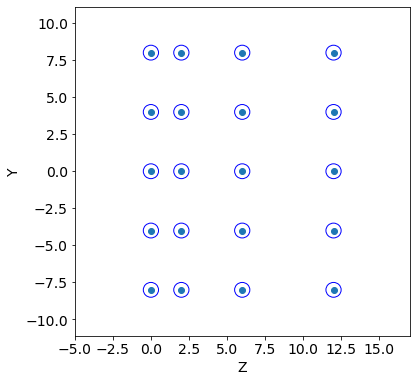

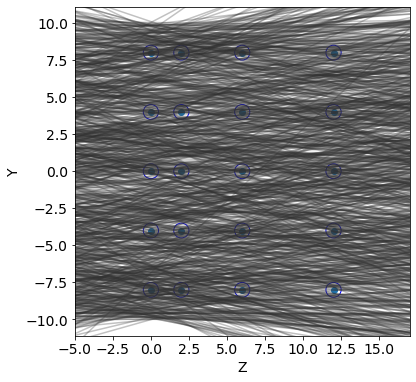

fraction of tracks detected:  0.264
resolution:  0.24613882479204957


In [3]:
# CONSTANT PARAMETERS
#------ define mother region ------#
y_min=-10.1
y_max=10.1
N_tracks = 1000


print("::::: BASELINE PARAMETERS :::::")
R = .5  
pitch = 4.0  
y1 = 0.0
y2 = 0.0
y3 = 0.0
z1 = 2.0
z2 = 4.0
z3 = 6.0

print("R, pitch, y1, y2, y3, z1, z2, z3: ", R, pitch, y1, y2, y3, z1, z2, z3,"\n")


#------------- GEOMETRY ---------------#
print(":::: INITIAL GEOMETRY ::::")
tr = detector2.Tracker(R, pitch, y1, y2, y3, z1, z2, z3)
Z, Y = tr.create_geometry()
num_wires = detector2.calculate_wires(Y, y_min, y_max)

volume = detector2.wires_volume(Y, y_min, y_max,R)

detector2.geometry_display(Z, Y, R, y_min=y_min, y_max=y_max,block=False,pause=5) #5

print("# of wires: ", num_wires, ", volume: ", volume)

#------------- TRACK GENERATION -----------#
print(":::: TRACK GENERATION ::::")
t = detector2.Tracks(b_min=y_min, b_max=y_max, alpha_mean=0, alpha_std=0.2) #-100,100
tracks = t.generate(N_tracks)

detector2.geometry_display(Z, Y, R, y_min=y_min, y_max=y_max,block=False, pause=-1)
detector2.tracks_display(tracks, Z,block=False,pause=-1)

 #a track is detected if at least two wires have been hit
score = detector2.get_score(Z, Y, tracks, R)
frac_detected = score[0]
resolution = score[1]
print("fraction of tracks detected: ",frac_detected)
print("resolution: ",resolution)


---

### Define Objectives 



Defines a class for the objectives of the problem that can be used in the MOO.  

In [4]:

class objectives():

  def __init__(self,tracks,y_min,y_max):
    self.tracks = tracks
    self.y_min = y_min
    self.y_max = y_max

  def wrapper_geometry(fun):

      def inner(self):
          R, pitch, y1, y2, y3, z1, z2, z3 = self.X
          self.geometry(R, pitch, y1, y2, y3, z1, z2, z3)
          return fun(self)
      return inner

  def update_tracks(self, new_tracks):
    self.tracks = new_tracks

  def update_design_point(self,X):
      self.X = X


  def geometry(self,R, pitch, y1, y2, y3, z1, z2, z3):
    tr = detector2.Tracker(R, pitch, y1, y2, y3, z1, z2, z3)
    self.R = R
    self.Z, self.Y = tr.create_geometry()


  @wrapper_geometry
  def calc_score(self):
      res = detector2.get_score(self.Z, self.Y, self.tracks, self.R)
      assert res[0] >= 0 and res[1] >= 0,"Fraction or Resolution negative."
      
      return res

  
  def get_score(self,X):
    R, pitch, y1, y2, y3, z1, z2, z3 = X
    self.geometry(R, pitch, y1, y2, y3, z1, z2, z3)
    res = detector2.get_score(self.Z, self.Y, self.tracks, self.R)
    return res
  

  def get_volume(self):
    volume = detector2.wires_volume(self.Y, self.y_min, self.y_max,self.R)
    return volume



res = objectives(tracks,y_min,y_max)

#res.geometry(R, pitch, y1, y2, y3, z1, z2, z3)

X = R, pitch, y1, y2, y3, z1, z2, z3
#fscore  = res.get_score(X)
res.update_design_point(X)
fscore  = res.calc_score()[0]
fvolume = res.get_volume()

print("...check: ", fvolume, fscore)



...check:  62.800000000000004 0.264


---
# Multi-Objective Optimization

We will be using pymoo (https://pymoo.org/getting_started.html).  

* In the constructor method we specify number of variables N, objectives M, and constraint functions, as well as the lower and upper boundaries of each variable. In our toy model, these boundaries are taken in such a way that all solutions are feasible and no constraint function is needed. You can try to change this and introduce some constraint. 



* The *_evaluate* method takes a one-dimensional NumPy array x number of entries equal to n_var. This behavior is enabled by setting *elementwise_evaluation=True* while calling the super() method. 

* Notice that every function is minimized. Our efficiency is defined as an tracking inefficiency = 1 - efficiency

* We add the resolution as a third objective.  The average residual of the track hit from the wire centre is used as a proxy for the resolution for this toy-model




In [5]:

class MyProblem(ElementwiseProblem): 
    "Note that this is a change in pymoo 0.050, seperate methods for elementwise and vectorised problem"

    #--------- vectorized ---------#

    def __init__(self):
        super().__init__(n_var=8,
                         n_obj=3,   #<------------ 
                         n_constr=0,
                         xl=np.array([0.5,2.5,0.,0.,0.,2.,2.,2.]),
                         xu=np.array([1.0,5.0,4.,4.,4.,10.,10.,10.]))

    def _evaluate(self, x, out, *args, **kwargs):


        f1 = 1.-res.get_score(x)[0]
        f2 = res.get_volume()
        f3 = res.get_score(x)[1]

        out["F"] = [f1, f2, f3]
   




### Creation of Problem and choice of optimization algorithm. 


* We will use NSGA-II, as explained in the lectures. You can decide the population size and the number of offsprings, based on what we discussed. 


* Pymoo offers different algorithms that can be used which are highly customizable and can be easily extended.
https://pymoo.org/algorithms/index.html


* Before dealing with a problem, it's useful to compare with a list of test problems reported in https://pymoo.org/problems/index.html, where different scenarios in terms of Variables, Objectives, Constraints are described. 



In [6]:
problem = MyProblem()


algorithm = NSGA2(pop_size=100,n_offsprings=20) #n_offsprings=10

res = minimize(problem,
               algorithm,
               ("n_gen", 500),
               verbose=True,
               seed=1,
               save_history=True)

n_gen |  n_eval |  n_nds  |     eps      |  indicator  
    1 |     100 |      18 |            - |            -
    2 |     120 |      23 |  0.060606061 |        ideal
    3 |     140 |      24 |  0.005479452 |        ideal
    4 |     160 |      30 |  0.015591598 |            f
    5 |     180 |      33 |  0.010882192 |            f
    6 |     200 |      33 |  0.047701144 |        ideal
    7 |     220 |      40 |  0.014804845 |        ideal
    8 |     240 |      40 |  0.005354752 |        ideal
    9 |     260 |      43 |  0.014511873 |        ideal
   10 |     280 |      42 |  0.005249344 |        ideal
   11 |     300 |      41 |  0.003791277 |            f
   12 |     320 |      47 |  0.009923126 |            f
   13 |     340 |      50 |  0.005221932 |        ideal
   14 |     360 |      48 |  0.004564563 |            f
   15 |     380 |      48 |  0.009994316 |        ideal
   16 |     400 |      51 |  0.001948492 |            f
   17 |     420 |      54 |  0.011950084 |      

## Analysis of Results 


In [16]:
ipv.figure()
s = ipv.scatter(res.F[:, 0], res.F[:, 1], res.F[:, 2], marker='sphere', size=2)
    #ipv.xyzlim(-1, 1)
ipv.xlabel('Ineff')
ipv.ylabel('Vol')
ipv.zlabel('Res')
ipv.animation_control(s) # shows controls for animation controls
ipv.save("3D_scatter.html")

print(np.shape(res.F[:, 0]))
print(type(res.F[:, 0]))

(100,)
<class 'numpy.ndarray'>


N.b.: the scatter plot has been produced with ipyvolume and saved as html file. 

Download the file 3D_scatter.html and open it interactively with a browser. 

---
# Post-processing: Metrics and Decision Making  

In [8]:

#-----------------------------------#
#          Post-Processing          #
#-----------------------------------#
#------------------------------------------------------------------------------#

n_evals = []    # corresponding number of function evaluations\
F = []          # the objective space values in each generation
cv = []         # constraint violation in each generation


# iterate over the deepcopies of algorithms
for algorithm in res.history:

    # store the number of function evaluations
    n_evals.append(algorithm.evaluator.n_eval)

    # retrieve the optimum from the algorithm
    opt = algorithm.opt

    # store the least contraint violation in this generation (in case this happens)
    cv.append(opt.get("CV").min())

    # filter out only the feasible and append
    feas = np.where(opt.get("feasible"))[0]
    _F = opt.get("F")[feas]
    F.append(_F)

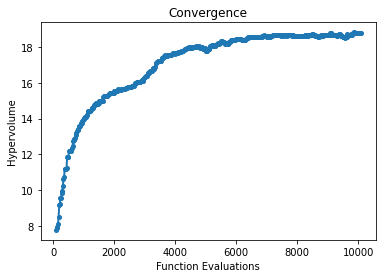

In [9]:
#--------------------------------------------------------------------------#
#                          METRICS: HyperVolume
#--------------------------------------------------------------------------#

# MODIFY - this is problem dependend
ref_point = np.array([0.5, 300, 0.5])

# create the performance indicator object with reference point
metric = get_performance_indicator("hv", ref_point=ref_point, normalize=False) # modified to be compatible with pymoo 0.5.0


# calculate for each generation the HV metric
hv = [metric.do(f) for f in F]  #F, or res.F , Also in pymoo 0.5.0 it is metric.do(A) not metric.calc(A)


# visualze the convergence curve
plt.plot(n_evals, hv, '-o', markersize=4, linewidth=2) #n_evals
plt.title("Convergence")
plt.xlabel("Function Evaluations")
plt.ylabel("Hypervolume")
plt.show()

---
## Decision Making 


In [10]:
#--------------------------------------------------------------------------#
#                           PSEUDO-WEIGHTS
#--------------------------------------------------------------------------#

# The obtained trade-off Pareto solutions can be assigned a pseudo-weight
# (on each direction of the objexctive space, the pseudo-weight will range in [0,1])
# where (1,0) means small f1 (x) and large f2 (y).
# The values of the pseudo-weights will depend on the position of the points on the Pareto front
# After a pseudo-weight is assigned to each solution, the one closer to the decision maker's wish may be selected


weights_a = np.array([0., 0., 0.])
a, pseudo_weights_a = get_decision_making("pseudo-weights", weights_a).do(res.F, return_pseudo_weights=True)

weights_b = np.array([0.5, 0.5, 0.5])
b, pseudo_weights_b = get_decision_making("pseudo-weights", weights_b).do(res.F, return_pseudo_weights=True)

weights_c = np.array([1.0, 0.5, 0.75])
c, pseudo_weights_c = get_decision_making("pseudo-weights", weights_c).do(res.F, return_pseudo_weights=True)


print(a)
print(b)
print(c)
print(res.F[a])
print(res.F[[a,b,c]])


print("...weights: ", weights_a)
#print("...pseudo_weights: ", pseudo_weights_a)
X_par = res.X
idx_opt = a
X_opt_a = X_par[idx_opt, :]
res_a = res.F[idx_opt]
print("...solution and objectives")
print(X_opt_a)
print(res.F[idx_opt])

print("")

print("...weights: ", weights_b)
#print("...pseudo_weights: ", pseudo_weights_b)
idx_opt = b
X_opt_b = X_par[idx_opt, :]
res_b = res.F[idx_opt]
print("...solution and objectives")
print(X_opt_b)
print(res.F[idx_opt])

print("")

print("...weights: ", weights_c)
#print("...pseudo_weights: ", pseudo_weights_c)
idx_opt = c
X_opt_c = X_par[idx_opt, :]
res_c = res.F[idx_opt]
print("...solution and objectives")
print(X_opt_c)
print(res.F[idx_opt])





11
32
29
[ 0.612      68.58756038  0.24222794]
[[6.12000000e-01 6.85875604e+01 2.42227937e-01]
 [3.29000000e-01 1.12432264e+02 2.62038071e-01]
 [1.03000000e-01 1.68924282e+02 3.30177921e-01]]
...weights:  [0. 0. 0.]
...solution and objectives
[0.50993898 3.56640941 3.11298412 1.45897099 3.00268646 2.14297031
 2.03007459 2.07573321]
[ 0.612      68.58756038  0.24222794]

...weights:  [0.5 0.5 0.5]
...solution and objectives
[0.52082724 2.50409142 1.3123387  1.39407057 3.70112674 2.07128115
 2.29880639 2.08560326]
[  0.329      112.43226403   0.26203807]

...weights:  [1.   0.5  0.75]
...solution and objectives
[0.66956168 2.53285649 1.25567557 1.26378547 3.6515705  2.1812176
 2.39643472 2.06366745]
[1.03000000e-01 1.68924282e+02 3.30177921e-01]


---
## Visualizations

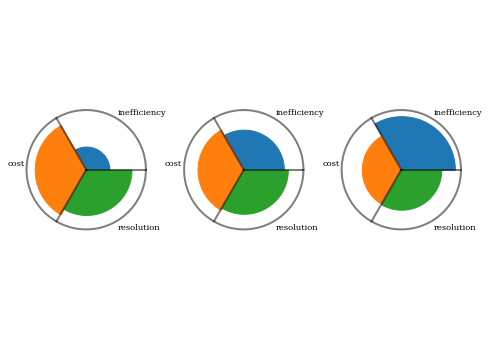

In [11]:
#------------------------- VISUALIZATIONS -------------------------------------#

plot = get_visualization("petal", bounds=[[0.,0.,0.],[1.0,500,1.]], reverse=True,\
                         labels=["inefficiency","cost","resolution"]) 
# the boundaries for normalization purposes (does not apply for every plot)
# either 2d array [[min1,..minN],[max1,...,maxN]] or just two numbers [min,max]
# bounds=[0,1],
plot.add(res.F[[a, b, c]])
#plot.add(res.F[a])
#plot.add(res.F[b])
#plot.add(res.F[c])

plot.show()

[ 0.612      68.58756038  0.24222794]
[  0.329      112.43226403   0.26203807]
[1.03000000e-01 1.68924282e+02 3.30177921e-01]


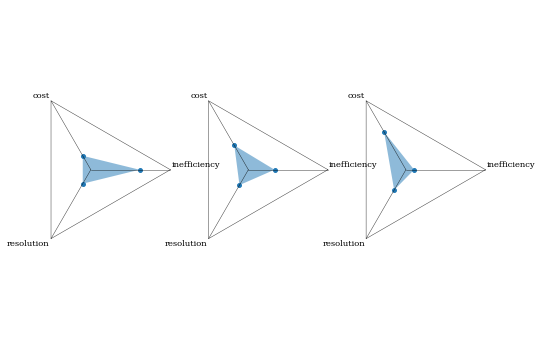

In [12]:
from pymoo.visualization.radar import Radar

ideal_point = np.array([0.0, 10, 0.05])
nadir_point = np.array([1.0, 300, 1.0])

# But if the scale of the objective is too different,
# then normalization is recommended. Then, the ideal point is just the point in the middle, 
# and the nadir point is now symmetric.

plot = Radar(bounds=[ideal_point, nadir_point], normalize_each_objective=True,\
             labels=["inefficiency","cost","resolution"])

plot.add(res.F[[a, b, c]])
#plot.add(res_a)
#plot.add(res_b)
#plot.add(res_c)
plot.show()

print(res_a)
print(res_b)
print(res_c)

## Plotting optimal geometry 

[0.66956168 2.53285649 1.25567557 1.26378547 3.6515705  2.1812176
 2.39643472 2.06366745]
[1.03000000e-01 1.68924282e+02 3.30177921e-01]
-10.1 10.1
:::: OPTIMAL GEOMETRY ::::


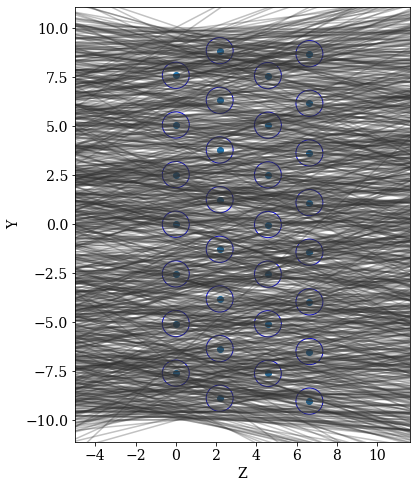

fraction of tracks detected:  0.897
volume:  168.9242817147181
resolution:  0.3301779209661302


In [13]:
#--------------------------------------------------------------------------#
#                   PLOT CORRESPONDING GEOMETRY
#--------------------------------------------------------------------------#
    

X_opt = X_opt_c # or any other point in the Pareto set

print(X_opt_c)
print(res_c)

print(detector2.y_min, detector2.y_max)

R, pitch, y1, y2, y3, z1, z2, z3 = X_opt

#R = 0.5

#------------- GEOMETRY ---------------#
print(":::: OPTIMAL GEOMETRY ::::")

tr = detector2.Tracker(R, pitch, y1, y2, y3, z1, z2, z3)
Z, Y = tr.create_geometry()
num_wires = detector2.calculate_wires(Y, y_min, y_max)

volume = detector2.wires_volume(Y, y_min, y_max,R)

detector2.geometry_display(Z, Y, R, y_min=y_min, y_max=y_max,block=False, pause=-1)
detector2.tracks_display(tracks, Z,block=False,pause=-1)

#a track is detected if at least two wires have been hit
score = detector2.get_score(Z, Y, tracks, R)
frac_detected = score[0]
resolution = score[1]
print("fraction of tracks detected: ",frac_detected)
print("volume: ",volume)
print("resolution: ",resolution)